# Extract-Transform-Load (ETL) Pipeline
This notebook implements the ETL process for the three MySQL tables:  
- *evaluation_quizzes*  
- *evaluation_quiz_questions*  
- *evaluation_quiz_corrections* 

In [43]:
# Install required libraries (uncomment if running outside Docker)
# !pip install --quiet -r requirements_colab.txt

## Table of Contents

1. **Extraction**
2. **Initial Data Inspection**
3. **Cleaning & Normalization**
4. **JSON Parsing**   
5. **Feature Generation**
6. **Save Intermediate Outputs**
7. **ETL Specification**

## 1. Extraction

First, we need to load the data from the CSV files. The CSV files are in the same directory as this script.<br>
The CSV files are:<br>
    - quizzes.csv: contains the quiz data<br>
    - questions.csv: contains the question data<br>
    - corrections.csv: contains the correction data

In [44]:
import pandas as pd

# Load CSV files into DataFrames
quizzes_df = pd.read_csv("data/quizzes.csv")
questions_df = pd.read_csv("data/questions.csv")
corrections_df = pd.read_csv("data/corrections.csv")

## 2. Initial Data Inspection


Then, we check for missing values, duplicates, and correct data types:

In [45]:
# Missing values and duplicates
for df, name in [(quizzes_df, "quizzes"),
                 (questions_df, "questions"),
                 (corrections_df, "corrections")]:
    print(f"{name} missing:\n", df.isna().sum())
    print(f"{name} duplicates:", df.duplicated().sum(), "\n")

# Data types
print("quizzes dtypes:\n", quizzes_df.dtypes)
print("questions dtypes:\n", questions_df.dtypes)
print("corrections dtypes:\n", corrections_df.dtypes)


quizzes missing:
 id                             0
created_at                     0
updated_at                     0
curriculum_id                106
online                         0
position                       0
days_offset                    0
name                           0
block_access                   0
time_allowed                   0
start_description             11
in_progress_description       17
end_description               16
overdue_description           19
allow_external_access          0
randomize_questions_order      0
add_as_scored_track            0
weight                         0
released_by_staff              0
released_at_specific_time      0
release_time                   0
author_id                     56
dtype: int64
quizzes duplicates: 0 

questions missing:
 id                       0
created_at               0
updated_at               0
evaluation_quiz_id       0
online                   0
position                 0
title                    0
sub_title 

It can be observed that there are no duplicated data, but there are several features with NULL fields. In principle, the case that I think is most important to discard are those corrections where the *data_json* feature is NULL, since without data from the students' answers, it is not possible to train any Knowledge Tracing model. These cases correspond to students who for some reason did not take the evaluations.

## 3. Cleaning & Normalization

In this section we are going to:<br>
- Remove unneeded rows from the dataframe *corrections_df*.
- Convert date columns to *datetime* (UTC) and complete NaT values
- Normalize categorical fields (strip, lower, fill missing)
- Handle nulls in key columns
- Rewrite original *category* using the normalized version and generate more generalized categories

## Delete of rows that we are not going to use

### Rows where *data_json* is NULL

In [46]:
# CAUTION: You need to run all cells if you want to run this cell again.

# We filter only rows with data_json present
print("Corrections data_json nulls:", corrections_df['data_json'].isnull().sum())
corrections_df = corrections_df.dropna(subset=['data_json'])

# Verify that rows with null data_json have been removed
# counting the number of null fields in the column 'data_json'.
print("Corrections data_json nulls after eliminatation:", corrections_df['data_json'].isnull().sum())

Corrections data_json nulls: 2111
Corrections data_json nulls after eliminatation: 0


### Corrections whose *id* is 5560, 5570 and 8363

Now we eliminate, based on the analysis performed during the Exploratory Data Analysis (EDA), the corrections whose *id* is 5560, 5570 and 8363, since none of these corrections corresponds to questions that are assessing any topic of the curricula of study.

In [47]:
# CAUTION: You need to run all cells if you want to run this cell again.

# Configure pandas display options to show all columns
pd.set_option("display.max_columns", None)  # Will show all columns
pd.set_option("display.width", 1000)        # Will not wrap lines
pd.set_option("display.colheader_justify", "center")  # Center column headers

# We print the rows of the dataframe corrections_df whose id is 5560, 5570 and 8363.
print("Corrections 5560, 5570 and 8363:")
print(corrections_df[corrections_df['id'].isin([5560, 5570, 8363])].to_string(index=False))

# Delete the rows of the dataframe corrections_df whose id is 5560, 5570 and 8363
corrections_df = corrections_df[~corrections_df['id'].isin([5560, 5570, 8363])]
# Check that the rows with id 5560, 5570 and 8363 have been deleted.
print(255 * "=")
print("Corrections 5560, 5570 and 8363 after eliminatation:", corrections_df[corrections_df['id'].isin([5560, 5570, 8363])])

Corrections 5560, 5570 and 8363:
 id       created_at          updated_at      user_id  batch_evaluation_quiz_item_id      start_time     end_time                                                                                                                                   data_json                                                                                                                                    skipped  skip_not_focus_impact  skip_late_impact
5560 2020-06-01 05:07:21 2020-06-02 18:59:14   1955                143               2020-06-02 18:59:04   NaN                                                                                                               {"question_answers":[{"id":1,"score":0,"answers":["I didn’t read one of these books"],"tmp":null,"not_focus_duration":null,"sumbitted_at":"2020-06-02 18:59:14"}]}    0               0                    0        
5570 2020-06-01 05:07:22 2020-06-02 15:59:18   1981                143               2020-06-02 15:

### Corrections without *question_answers* key in *data_json* field

From the analysis performed during the Exploratory Data Analysis (EDA), we were able to decide to discard those rows in the dataframe **corrections_df** where the key *question_answers* is not found in the *data_json* field.

In [48]:
# CAUTION: You need to run all cells if you want to run this cell again.

import json

# Define a helper to test for the presence of "question_answers"
def has_question_answers(json_str):
    try:
        data = json.loads(json_str)
        return "question_answers" in data
    except Exception:
        return False  # malformed or null JSON

# Build a mask of rows missing that key
mask_missing = ~corrections_df['data_json'].apply(has_question_answers)

# Count how many are missing
count_missing = mask_missing.sum()
print(f"Number of corrections without 'question_answers': {count_missing}")

# Delete the rows of the corrections_df dataframe that do not have the key "question_answers".
corrections_df = corrections_df[~mask_missing]

# Check that rows with null "question_answers" key have been deleted
remaining_missing = ~corrections_df['data_json'].apply(has_question_answers)
count_remaining_missing = remaining_missing.sum()
print(f"Number of corrections without 'question_answers' after elimination: {count_remaining_missing}")

Number of corrections without 'question_answers': 10103
Number of corrections without 'question_answers' after elimination: 0


## Normalize question categories

Now, we normalize the categories to make them easier to handle. To do this, we remove the blanks, convert to lowercase, fill in the fields that do not contain a defined category with the string "unknown" and rewrite the *category* column.

In [49]:
# Normalize category (strip, lowercase, fill missing)
questions_df['category'] = (
    questions_df['category']
        .fillna('unknown')    # Fill missing categories with 'unknown'
        .astype(str)
        .str.strip()
        .str.lower()
)

# Inspect unique categories after normalizing
print("Unique normalized categories:", questions_df['category'].unique())

Unique normalized categories: ['unknown' 'c' 'math' 'binary' 'matrices' 'javascript' 'sql' 'big o'
 'html/css' 'ascii' 'python' 'linux' 'about you'
 'your studies & your work experience' 'your coding experience'
 'housing & financing' 'you & holberton' 'shell' 'sysadmin' 'network'
 'big(o)' 'regex' 'networking' 'make' 'algorithm' 'c, singly linked list'
 'data structures' 'memory management' 'c, memory management'
 'sorting algorithm' 'bash' 'binary tree' 'web infrastructure'
 'orm, sqlalchemy' 'api' 'documentation' 'monitoring' 'precalculus'
 'linear algebra' 'calculus' 'probability' 'c - pointer' 'for loops'
 'database' 'databases' 'bit manipulation' 'http' 'flask' 'mysql'
 'python3' 'python#' 'airbnb' 'html' 'css' 'nosql' 'pagination' 'js'
 'jquery' 'scaping' 'git' 'makefile' 'hmtl' 'web framework'
 'web development' 'uml' 'docker']


## Elimination of responses to unnecessary categories

We now proceed to eliminate the answers within the dataframe **corrections_df** corresponding to the categories *About you*, *Your studies & your work experience*, *You & Holberton*, *Your Coding Experience*, and *Housing & Financing*, since those answers correspond to questions are not evaluating any topic of the curricula of study.

In [50]:
# Categories to exclude and get their question IDs
exclude_cats = [
    "about you",
    "your studies & your work experience",
    "you & holberton",
    "your coding experience",
    "housing & financing"
]
exclude_qids = set(
    questions_df.loc[
        questions_df['category'].isin(exclude_cats),
        'id'
    ].tolist()
)

# Function to count excluded answers in a single JSON
def count_excluded_answers(json_str):
    try:
        data = json.loads(json_str)
        return sum(
            1
            for ans in data.get('question_answers', [])
            if ans.get('id') in exclude_qids
        )
    except Exception:
        return 0

# Count total excluded answers before removal
corrections_df['num_excluded_before'] = corrections_df['data_json'] \
    .apply(count_excluded_answers)
total_before = corrections_df['num_excluded_before'].sum()
print(f"Total answers in excluded categories BEFORE removal: {total_before}")

# Function to remove those answers
def remove_excluded_answers(json_str):
    try:
        data = json.loads(json_str)
        filtered = [
            ans for ans in data.get('question_answers', [])
            if ans.get('id') not in exclude_qids
        ]
        data['question_answers'] = filtered
        return json.dumps(data)
    except Exception:
        return json_str

# Apply removal
corrections_df['data_json'] = corrections_df['data_json'] \
    .apply(remove_excluded_answers)

# Re-count to verify
corrections_df['num_excluded_after'] = corrections_df['data_json'] \
    .apply(count_excluded_answers)
total_after = corrections_df['num_excluded_after'].sum()
print(f"Total answers in excluded categories AFTER removal:  {total_after}")

# We can now drop the helper columns
corrections_df = corrections_df.drop(columns=['num_excluded_before', 'num_excluded_after'])

# Show the category distribution of the remaining responses
# First, exploit all question_ids
flat_qids = []
for js in corrections_df['data_json']:
    try:
        obj = json.loads(js)
        flat_qids.extend([ans['id'] for ans in obj.get('question_answers', [])])
    except:
        continue

flat_df = pd.DataFrame({'question_id': flat_qids})
flat_df = flat_df.merge(
    questions_df[['id','category']],
    left_on='question_id',
    right_on='id',
    how='left'
)

pd.set_option("display.max_rows", None)  # Will show all rows

print("\nRemaining categories distribution:")
print(flat_df['category'].value_counts().to_string(index=True))


Total answers in excluded categories BEFORE removal: 59495
Total answers in excluded categories AFTER removal:  0

Remaining categories distribution:
category
c                        260999
python                    64865
unknown                   58873
linux                     28437
math                      24795
html/css                  24425
shell                     22534
sql                       20081
javascript                14687
binary                    12244
network                   12217
networking                10400
big o                      6694
ascii                      6623
big(o)                     5485
python3                    5400
sysadmin                   4818
matrices                   4502
mysql                      3371
regex                      3327
api                        3269
algorithm                  3047
sorting algorithm          2693
data structures            2582
js                         2534
airbnb                     1932
c, memory

Finally we proceed to delete the rows of the **questions_df** dataframe whose category is *About you*, *Your studies & your work experience*, *You & Holberton*, *Your Coding Experience*, or *Housing & Financing*.

In [51]:
# We delete the rows of the dataframe questions_df whose category is in the exclude_cats list.
questions_df = questions_df[~questions_df['category'].isin(exclude_cats)]

# We print the number of questions per category to verify that the rows have been removed from the questions_df
# dataframe whose category is in the exclude_cats list.
print("Questions categories after eliminatation:")
print(questions_df['category'].value_counts().to_string(index=True))


Questions categories after eliminatation:
category
c                        539
unknown                  452
python                   301
shell                    116
js                       114
python3                   63
linux                     55
networking                50
network                   47
sql                       41
javascript                35
math                      33
html/css                  33
api                       29
mysql                     19
binary                    17
big(o)                    15
airbnb                    15
nosql                     13
git                       13
http                      13
linear algebra            12
web development           11
databases                 10
calculus                  10
precalculus               10
sysadmin                  10
docker                     9
big o                      9
regex                      9
ascii                      9
data structures            8
algorithm            

## Elimination of answers without associated questions

We proceed now, as considered during the EDA, to eliminate those questions where the *id* of the question does not correspond to any question of the **questions_df** dataframe, since there is a need to have information from the questions and to be able to obtain the information of the category to which the answer corresponds (which is linked through the *evaluation_quiz_id* field of the **questions_df** dataframe).


In [52]:
# We prepare a valid set of question IDs
valid_qids = set(questions_df['id'].astype(int).tolist())

# Function that counts how many responses are invalid in a given JSON
def count_invalid(js):
    """ Count invalid question_answers in a JSON string. """
    try:
        obj = json.loads(js)
        qas = obj.get('question_answers', [])
        return sum(1 for ans in qas 
                   if 'id' not in ans or int(ans['id']) not in valid_qids)
    except:
        return 0

# Counting before cleaning
invalid_counts_before = corrections_df['data_json'].apply(count_invalid)
total_invalid_before = invalid_counts_before.sum()
print(f"Total of responses WITHOUT associated question before filtering: {total_invalid_before}")

# Function that filters the list of question_answers
def cleanse_json(js):
    """ Keep only valid question_answers in a JSON string. """
    try:
        obj = json.loads(js)
        qas = obj.get('question_answers', [])
        # keep only those with id in valid_qids
        filtered = [ans for ans in qas 
                    if 'id' in ans and int(ans['id']) in valid_qids]
        obj['question_answers'] = filtered
        return json.dumps(obj)
    except:
        # if it is not JSON or is malformed, return it unchanged
        return js

# Apply cleaning
corrections_df['data_json'] = corrections_df['data_json'].apply(cleanse_json)

# Delete rows where question_answers is empty
def has_answers(js):
    """ Check if question_answers is not empty in a JSON string. """
    try:
        return len(json.loads(js).get('question_answers', [])) > 0
    except:
        return False

mask_keep = corrections_df['data_json'].apply(lambda x: 'question_answers' in json.loads(x) and
                                              len(json.loads(x)['question_answers']) > 0)
corrections_df = corrections_df[mask_keep]

# Counting after cleaning
invalid_counts_after = corrections_df['data_json'].apply(count_invalid)
total_invalid_after = invalid_counts_after.sum()
print(f"Total responses WITHOUT associated question after filtering: {total_invalid_after}")

# See how many corrections have been removed
print(f"Total corrections removed after applying the filter: {len(invalid_counts_before) - len(corrections_df)}")



Total of responses WITHOUT associated question before filtering: 2034
Total responses WITHOUT associated question after filtering: 0
Total corrections removed after applying the filter: 2148


Finally, we proceed to check the types of questions that ended up remaining after the previous eliminations:

In [53]:
print(questions_df['question_type'].value_counts().to_string())

question_type
Checkbox          2035
Input               85
Scored              39
SelectMultiple      34
Select              23


### Removal of rows of category *unknown*.

First we eliminate the answers whose question is of category *unknown* and at the same time the question is of type *SelectMultiple, Input, Select* or *Scored*.

In [54]:
# Normalize question_type (strip, lowercase)
questions_df['question_type'] = (
    questions_df['question_type']
        .fillna('')
        .astype(str)
        .str.strip()
        .str.lower()
)

qtype_to_exclude = ["selectmultiple", "input", "select", "scored"]

# Set of question IDs for excluded question types with category 'unknown'
exclude_qids = set(
    questions_df.loc[
        (questions_df['category'] == 'unknown') &
        (questions_df['question_type'].isin(qtype_to_exclude)),
        'id'
    ].tolist()
)

# Function to count how many excluded-unknown answers are in one JSON
import json
def count_answers(json_str):
    try:
        data = json.loads(json_str)
        return sum(
            1
            for ans in data.get('question_answers', [])
            if ans.get('id') in exclude_qids
        )
    except:
        return 0

# Count total excluded-unknown answers BEFORE removal
corrections_df['before'] = corrections_df['data_json'].apply(count_answers)
total_before = corrections_df['before'].sum()
print(f"Total answers with unknown category and type SelectMultiple, Input, Select or Scored, BEFORE removal: {total_before}")

# We can now drop the helper column
corrections_df = corrections_df.drop(columns=['before'])

# Function to remove those answers from the JSON
def remove_answers(json_str):
    try:
        data = json.loads(json_str)
        filtered = [
            ans for ans in data.get('question_answers', [])
            if ans.get('id') not in exclude_qids
        ]
        data['question_answers'] = filtered
        return json.dumps(data)
    except:
        return json_str

# Apply removal
corrections_df['data_json'] = corrections_df['data_json'].apply(remove_answers)

# Re-count to verify AFTER removal
corrections_df['after'] = corrections_df['data_json'].apply(count_answers)
total_after = corrections_df['after'].sum()
print(f"Total answers with unknown category and type SelectMultiple, Input, Select or Scored, AFTER removal:  {total_after}")

# We can now drop the helper column
corrections_df = corrections_df.drop(columns=['after'])

Total answers with unknown category and type SelectMultiple, Input, Select or Scored, BEFORE removal: 25803
Total answers with unknown category and type SelectMultiple, Input, Select or Scored, AFTER removal:  0


Finally we proceed to delete the rows of the dataframe **questions_df** whose category is *unknown*, and whose type is *SelectMultiple, Input, Select* or *Scored*.

In [55]:
# Count rows with category "unknown" AND question_type in qtype_to_exclude
mask_exclude_unknown = (
    (questions_df['category'] == 'unknown') &
    (questions_df['question_type'].isin(qtype_to_exclude))
)
count_before = mask_exclude_unknown.sum()
print(f"Total questions with unknown category and type SelectMultiple, Input, Select or Scored, BEFORE removal: {count_before}")

# Remove those rows from questions_df
questions_df = questions_df.loc[~mask_exclude_unknown].copy()

# Re-count to verify removal
mask_exclude_unknown_after = (
    (questions_df['category'] == 'unknown') &
    (questions_df['question_type'].isin(qtype_to_exclude))
)
count_after = mask_exclude_unknown_after.sum()
print(f"Total questions with unknown category and type SelectMultiple, Input, Select or Scored, AFTER removal:  {count_after}")


Total questions with unknown category and type SelectMultiple, Input, Select or Scored, BEFORE removal: 145
Total questions with unknown category and type SelectMultiple, Input, Select or Scored, AFTER removal:  0


The answers in the dataframe **corrections_df** whose question category is *unknown*, the *question_type* field is *Checkbox* and the value of the *evaluation_quiz_id* field is 38, 106 or 149 in the dataframe **questions_df** will also be eliminated; since, as analyzed during the EDA, they do not correspond to any topic of the study curricula or are test questions.

In [56]:
# Identify question IDs to remove: category="unknown", qtype="checkbox", quiz in [38,106,149]
target_qids = set(
    questions_df.loc[
        (questions_df['category'] == 'unknown') &
        (questions_df['question_type'] == 'checkbox') &
        (questions_df['evaluation_quiz_id'].isin([38, 106, 149])),
        'id'
    ].tolist()
)

# Count how many answer entries match those qids BEFORE removal
def count_target_answers(json_str):
    """Return number of answers in this JSON whose id is in target_qids."""
    try:
        data = json.loads(json_str)
        return sum(1 for ans in data.get('question_answers', []) if ans.get('id') in target_qids)
    except:
        return 0

corrections_df['num_target_before'] = corrections_df['data_json'].apply(count_target_answers)
total_before = corrections_df['num_target_before'].sum()
print(f"Total answers to REMOVE BEFORE: {total_before}")

# We can now drop the helper column
corrections_df = corrections_df.drop(columns=['num_target_before'])

# Remove those answer entries from each JSON
def remove_target_answers(json_str):
    """Return JSON string with all answers having id in target_qids removed."""
    try:
        data = json.loads(json_str)
        filtered = [ans for ans in data.get('question_answers', []) if ans.get('id') not in target_qids]
        data['question_answers'] = filtered
        return json.dumps(data)
    except:
        return json_str

corrections_df['data_json'] = corrections_df['data_json'].apply(remove_target_answers)

# Count again to verify removal
corrections_df['num_target_after'] = corrections_df['data_json'].apply(count_target_answers)
total_after = corrections_df['num_target_after'].sum()
print(f"Total answers to REMOVE AFTER:  {total_after}")

# We can now drop the helper column
corrections_df = corrections_df.drop(columns=['num_target_after'])


Total answers to REMOVE BEFORE: 1
Total answers to REMOVE AFTER:  0


Then we proceed to delete the rows of the dataframe **questions_df** whose question is of the category *unknown*, the *question_type* field is *Checkbox* and the value of the *evaluation_quiz_id* field is 38, 106 or 149:

In [57]:
# Count rows with category="unknown", qtype="checkbox", quiz in [38,106,149]
mask_exclude = (
    (questions_df['category'] == 'unknown') &
    (questions_df['question_type'] == 'checkbox') &
    (questions_df['evaluation_quiz_id'].isin([38, 106, 149]))
)
count_before = mask_exclude.sum()
print(f"Total questions with unknown category, checkbox qtype and quiz in [38,106,149], BEFORE removal: {count_before}")

# Remove those rows from questions_df
questions_df = questions_df.loc[~mask_exclude].copy()

# Re-count to verify removal
mask_exclude_after = (
    (questions_df['category'] == 'unknown') &
    (questions_df['question_type'] == 'checkbox') &
    (questions_df['evaluation_quiz_id'].isin([38, 106, 149]))
)
count_after = mask_exclude_after.sum()
print(f"Total questions with unknown category, checkbox qtype and quiz in [38,106,149], AFTER removal:  {count_after}")


Total questions with unknown category, checkbox qtype and quiz in [38,106,149], BEFORE removal: 3
Total questions with unknown category, checkbox qtype and quiz in [38,106,149], AFTER removal:  0


## Renaming *unknown* categories of type *Checkbox*.

We now proceed to rename the categories of type *unknown*, whose *question_type* field is *Checkbox* and whose *evaluation_quiz_id* field value is the one indicated during the EDA

In [58]:
# Here all your quiz‐ID groups and special positions are defined
python_q   = {15, 35, 43, 62, 65, 129}
shell_q    = {48, 66, 144}
c_q        = {49, 53, 59, 68, 69, 75, 92, 114, 133, 143}
git_q      = {57}
html_q     = {72}
sql_q      = {74}
jquery_q   = {95}
webdev_q   = {113}

# For quiz 64 and 145 we need to inspect 'position'
shell_64_positions  = {1, 2} | set(range(14,20)) | {21}
shell_145_positions = set(range(1,5)) | {7,8,9} | {11} | set(range(14,18))

git_64_positions    = set(range(3,14))
git_145_positions   = {5,6,10,12,13}

# Base mask: only those that are "unknown" + checkbox
base_mask = (
    (questions_df['category'] == 'unknown') &
    (questions_df['question_type'] == 'checkbox')
)

# Count how many questions match that mask
print("'unknown' + 'checkbox' questions BEFORE remap:", len(questions_df[base_mask]))

# Apply mappings for simple quiz_id groups
# theme -> set of quiz IDs
simple_map = {
    'python'         : python_q,
    'shell'          : shell_q,
    'c'              : c_q,
    'git'            : git_q,
    'html/css'       : html_q,
    'sql'            : sql_q,
    'jquery'         : jquery_q,
    'web development': webdev_q,
}

for theme, quiz_ids in simple_map.items():
    mask = base_mask & questions_df['evaluation_quiz_id'].isin(quiz_ids)
    questions_df.loc[mask, 'category'] = theme

# Now we handle the special cases for quiz 64 and 145
# Shell in quiz 64
mask_shell64 = base_mask & (questions_df['evaluation_quiz_id'] == 64) & questions_df['position'].isin(shell_64_positions)
questions_df.loc[mask_shell64, 'category'] = 'shell'

# Shell in quiz 145
mask_shell145 = base_mask & (questions_df['evaluation_quiz_id'] == 145) & questions_df['position'].isin(shell_145_positions)
questions_df.loc[mask_shell145, 'category'] = 'shell'

# Git in quiz 64
mask_git64 = base_mask & (questions_df['evaluation_quiz_id'] == 64) & questions_df['position'].isin(git_64_positions)
questions_df.loc[mask_git64, 'category'] = 'git'

# Git in quiz 145
mask_git145 = base_mask & (questions_df['evaluation_quiz_id'] == 145) & questions_df['position'].isin(git_145_positions)
questions_df.loc[mask_git145, 'category'] = 'git'

# Base mask after: only those that are "unknown" + checkbox
base_mask_after = (
    (questions_df['category'] == 'unknown') &
    (questions_df['question_type'] == 'checkbox')
)

# Verificación rápida
print("Remaining 'unknown' + 'checkbox' questions AFTER remap:", len(questions_df[base_mask_after]))

# Inspect unique categories after remapping
print(100 * "=")
print("Unique categories after remap:\n", questions_df['category'].unique())


'unknown' + 'checkbox' questions BEFORE remap: 304
Remaining 'unknown' + 'checkbox' questions AFTER remap: 0
Unique categories after remap:
 ['c' 'math' 'binary' 'matrices' 'javascript' 'sql' 'big o' 'html/css'
 'ascii' 'python' 'linux' 'shell' 'sysadmin' 'network' 'big(o)' 'regex'
 'networking' 'make' 'algorithm' 'c, singly linked list' 'data structures'
 'memory management' 'c, memory management' 'sorting algorithm' 'bash'
 'binary tree' 'web infrastructure' 'orm, sqlalchemy' 'api'
 'documentation' 'monitoring' 'precalculus' 'linear algebra' 'calculus'
 'probability' 'c - pointer' 'for loops' 'database' 'databases' 'git'
 'bit manipulation' 'http' 'flask' 'mysql' 'python3' 'python#' 'airbnb'
 'html' 'css' 'nosql' 'pagination' 'js' 'jquery' 'scaping' 'makefile'
 'hmtl' 'web development' 'web framework' 'uml' 'docker']


## Remove all *Input*-type questions and their answers


In this section we will do the following:
- Identify all question IDs in *questions_df* with *question_type == "Input"*.  
- In *corrections_df.data_json*, strip out any answer entries whose *id* is in that set.  
- Drop any corrections whose *question_answers* list becomes empty.  
- Drop those questions from *questions_df*.  
- Print counts before/after at each step.

In [59]:
# Identify all Input-type question IDs
input_qids = set(
    questions_df.loc[
        questions_df['question_type'].str.lower() == 'input',
        'id'
    ].astype(int)
)

# Count total answer-records in corrections_df referring to input_qids
def count_input_answers(js):
    try:
        data = json.loads(js)
        return sum(1 for ans in data.get('question_answers', [])
                   if int(ans.get('id', -1)) in input_qids)
    except:
        return 0

corrections_df['n_input_answers_before'] = corrections_df['data_json'].apply(count_input_answers)
total_input_answers_before = corrections_df['n_input_answers_before'].sum()
print("Total answer-records referring to Input-type questions BEFORE:", total_input_answers_before)

# We can now drop the helper column
corrections_df = corrections_df.drop(columns=['n_input_answers_before'])

# Remove those answers from each JSON
def remove_input_answers(js):
    try:
        obj = json.loads(js)
        filtered = [
            ans for ans in obj.get('question_answers', [])
            if int(ans.get('id', -1)) not in input_qids
        ]
        obj['question_answers'] = filtered
        return json.dumps(obj)
    except:
        return js

corrections_df['data_json'] = corrections_df['data_json'].apply(remove_input_answers)

# Recount how many Input-answers remain
corrections_df['n_input_answers_after'] = corrections_df['data_json'].apply(count_input_answers)
total_input_answers_after = corrections_df['n_input_answers_after'].sum()
print("Total answer-records referring to Input-type questions AFTER:", total_input_answers_after)

# We can now drop the helper column
corrections_df = corrections_df.drop(columns=['n_input_answers_after'])

# Finally drop those questions from questions_df
count_q_before = len(questions_df)
questions_df = questions_df[~questions_df['id'].isin(input_qids)].reset_index(drop=True)
count_q_after = len(questions_df)

# Print how many questions of type 'Input' will be removed
print("Questions of type 'Input' (to remove):", len(input_qids))
# Recount how many questions has been removed
print(f"Questions of type 'Input' removed: {count_q_before - count_q_after}")

Total answer-records referring to Input-type questions BEFORE: 380
Total answer-records referring to Input-type questions AFTER: 0
Questions of type 'Input' (to remove): 36
Questions of type 'Input' removed: 36


Finally, we proceed to check the types of questions that ended up remaining after the previous eliminations:

In [60]:
print(questions_df['question_type'].value_counts().to_string())

question_type
checkbox    2032


It can be verified that if we add the number of questions of type *selectmultiple*, *input*, *select* and *scored* whose category was *unknown* (145 questions) with those of type "input" that were subsequently eliminated (36 questions), we obtain exactly the sum of questions of type *selectmultiple*, *input*, *select* and *scored* that existed prior to the deletions, which tells us that all questions of type *selectmultiple*, *select* and *scored* corresponded to the *unknown* category.<br>
In fact, we can see in the above output, that after the previous deletions, the only question type that ended up remaining was of type *checkbox*. 

## Creating general categories

Next, a column with new, more general categories is generated, since there are too many categories to be considered as skills to be learned in Knowledge Tracing models, as well as too many categories with too few questions.

general_cat
C                       665
Python                  394
Shell                   241
Javascript              142
Networking & API        141
Databases & ORM         107
Web & Front-end          96
DevOps & Tools           85
Programming & Basics     84
Math & Stats             77


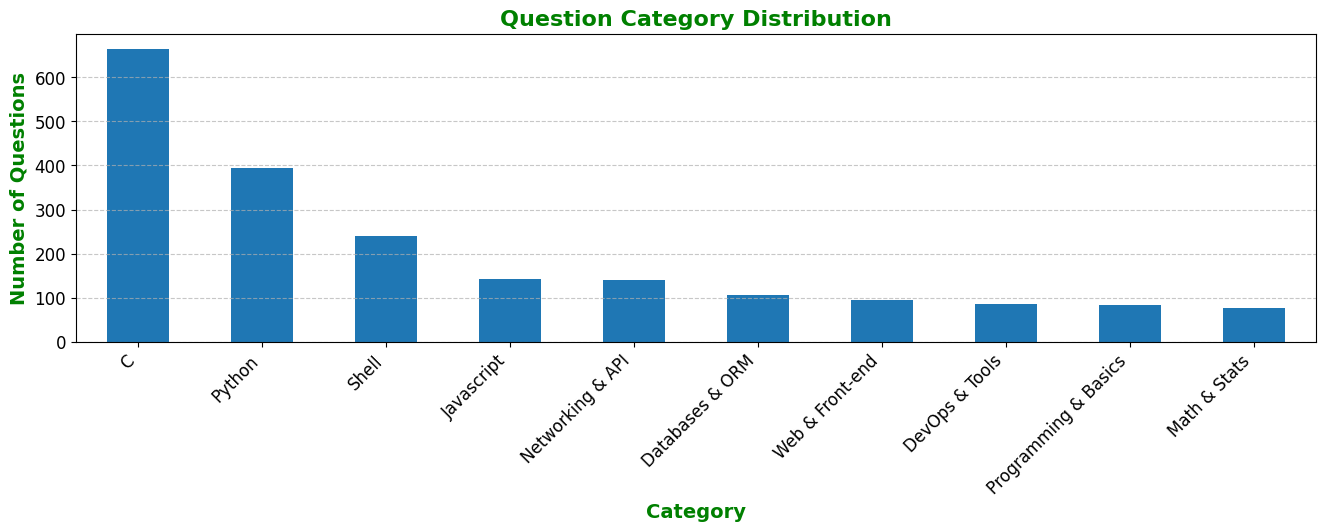

In [ ]:
import matplotlib.pyplot as plt
import os

# Define your high‐level category groups
group_map = {
    'C': [
        'c','c - pointer','c, memory management',
        'memory management', 'c, singly linked list'
    ],
    'Python': [
        'python','python3','python#'
    ],
    'Shell': [
        'shell','bash', 'linux'
    ],
    'Javascript': [
        'js','javascript'
    ],
    'Programming & Basics': [
        'ascii','for loops','bit manipulation',
        'data structures','algorithm','sorting algorithm',
        'binary','binary tree',
        'big(o)','big o', 'regex'
    ],
    'Web & Front-end': [
        'html/css','html','css',
        'jquery','web development','web framework',
        'pagination','scaping','flask','hmtl'
    ],
    'Databases & ORM': [
        'sql','mysql','nosql',
        'database','databases','orm, sqlalchemy'
    ],
    'Networking & API': [
        'networking','network','http','api','web infrastructure'
    ],
    'Math & Stats': [
        'math','calculus','precalculus','linear algebra',
        'probability','matrices'
    ],
    'DevOps & Tools': [
        'git','docker','sysadmin','monitoring', 'documentation',
        'make','makefile','airbnb', 'uml'
    ]
}

# Initialize the new column to "Other"
questions_df['general_cat'] = 'Other'

# Assign each question to its high-level category
for general, cat_list in group_map.items():
    mask = questions_df['category'].isin(cat_list)
    questions_df.loc[mask, 'general_cat'] = general

# Quick check: how many questions por grupo
print(questions_df['general_cat'].value_counts().to_string())

# Plot category distribution
questions_df['general_cat'].value_counts().plot(kind="bar", figsize=(16,4))
plt.title("Question Category Distribution", fontsize=16, fontweight="bold", color="Green")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category", fontsize=14, fontweight="bold", color="Green")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylabel("Number of Questions", fontsize=14, fontweight="bold", color="Green")

# Create the data directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Save the plot as an image
plt.savefig("images/general_cat_distribution.png", bbox_inches="tight", dpi=300)
# Show the plot
plt.show()


### Analysis of the total number of interactions and the different students by category

After generating the new more general categories, we proceed to check if the total number of answered questions (interactions) per category is greater than 200 and the number of different students interacting per category is greater than 30.

In [62]:
# Copy the corrections_df to avoid modifying the original DataFrame
corrections_copy = corrections_df.copy()

# Copy the questions_df to avoid modifying the original DataFrame
questions_copy = questions_df.copy()

# Explode valid_json into one row per answer
rows = []
for _, corr in corrections_copy.iterrows():
    user = corr['user_id']
    try:
        data = json.loads(corr['data_json'])
    except:
        continue
    for ans in data.get('question_answers', []):
        if 'id' not in ans:
            continue
        rows.append({
            'user_id':     user,
            'question_id': int(ans['id'])
        })

interactions = pd.DataFrame(rows)

# Join to questions_df on question_id → get category_norm
interactions = interactions.merge(
    questions_copy[['id','general_cat']],
    left_on='question_id',
    right_on='id',
    how='left'
).drop(columns=['id'])

# Aggregate per skill
skill_stats = interactions.groupby('general_cat').agg(
    interactions=('question_id','count'),
    students   =('user_id',   lambda s: s.nunique())
).reset_index()

# Show skills
display(skill_stats.sort_values('interactions', ascending=False).reset_index(drop=True))

,general_cat,interactions,students
0,C,273673,3383
1,Python,78778,2920
2,Shell,53881,3317
3,Programming & Basics,43776,2664
4,Math & Stats,33699,2290
5,Web & Front-end,31471,2496
6,Databases & ORM,29860,2740
7,Networking & API,27051,1404
8,Javascript,17144,2487
9,DevOps & Tools,13839,1647


As can be seen, having grouped all the categories into more general categories, the total number of answered questions (interactions) per category is over 200 and the number of different students interacting per category is over 30, so it is not necessary to discard any category.

## Redefine the time it took for the student to take the test

Let's redefine the time it took the student to perform the test, using the criteria seen during the EDA.

In [63]:
# Convert datetime fields (created_at, updated_at)
for df in [quizzes_df, questions_df, corrections_df]:
    for col in ['created_at', 'updated_at']:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S', utc=True, errors='coerce') # Convert invalid dates to NaT

# Convert start_time/end_time in corrections
for col in ['start_time', 'end_time']:
        corrections_df[col] = pd.to_datetime(corrections_df[col], format='%Y-%m-%d %H:%M:%S', utc=True, errors='coerce')

In [64]:
# We first check if there are any rows without the key 'question_answers'.
mask = corrections_df['data_json'].apply(lambda x: 'question_answers' not in json.loads(x))
# We count how many rows meet the condition
count = mask.sum()
print(f"Number of corrections without the key 'question_answers': {count}")
# We check if there is any row without answers to questions
mask = corrections_df['data_json'].apply(lambda x: 'question_answers' in json.loads(x) and len(json.loads(x)['question_answers']) == 0)
# We count how many rows meet the condition
count = mask.sum()
print(f"Number of corrections whose value of the key 'question_answers' is an empty list: {count}")
print(255 * "=")
# We print the first rows of the dataframe corrections_df that meet the above condition
display(corrections_df[mask].head(20).reset_index(drop=True))


Number of corrections without the key 'question_answers': 0
Number of corrections whose value of the key 'question_answers' is an empty list: 3344


,id,created_at,updated_at,user_id,batch_evaluation_quiz_item_id,start_time,end_time,data_json,skipped,skip_not_focus_impact,skip_late_impact
0,91,2018-06-15 07:05:41+00:00,2018-06-15 15:53:54+00:00,235,5,2018-06-15 15:50:00+00:00,2018-06-15 15:53:54+00:00,"{""question_answers"": []}",0,0,0
1,92,2018-06-15 07:05:41+00:00,2018-06-15 16:30:26+00:00,304,5,2018-06-15 16:25:12+00:00,2018-06-15 16:30:26+00:00,"{""question_answers"": []}",0,0,0
2,93,2018-06-15 07:05:41+00:00,2018-06-15 14:35:06+00:00,318,5,2018-06-15 14:26:14+00:00,2018-06-15 14:35:06+00:00,"{""question_answers"": []}",0,0,0
3,94,2018-06-15 07:05:41+00:00,2018-06-15 07:46:44+00:00,357,5,2018-06-15 07:39:41+00:00,2018-06-15 07:46:44+00:00,"{""question_answers"": []}",0,0,0
4,95,2018-06-15 07:05:41+00:00,2018-06-15 07:46:47+00:00,359,5,2018-06-15 07:35:00+00:00,2018-06-15 07:46:47+00:00,"{""question_answers"": []}",0,0,0
5,96,2018-06-15 07:05:41+00:00,2018-06-15 08:17:01+00:00,360,5,2018-06-15 08:12:57+00:00,2018-06-15 08:17:01+00:00,"{""question_answers"": []}",0,0,0
6,97,2018-06-15 07:05:41+00:00,2018-06-15 16:30:42+00:00,361,5,2018-06-15 15:50:17+00:00,2018-06-15 16:30:42+00:00,"{""question_answers"": []}",0,0,0
7,98,2018-06-15 07:05:41+00:00,2018-06-15 13:28:27+00:00,362,5,2018-06-15 13:23:33+00:00,2018-06-15 13:28:27+00:00,"{""question_answers"": []}",0,0,0
8,99,2018-06-15 07:05:41+00:00,2018-06-15 14:10:57+00:00,364,5,2018-06-15 14:05:13+00:00,2018-06-15 14:10:57+00:00,"{""question_answers"": []}",0,0,0
9,100,2018-06-15 07:05:41+00:00,2018-06-15 15:35:13+00:00,368,5,2018-06-15 15:05:26+00:00,2018-06-15 15:35:13+00:00,"{""question_answers"": []}",0,0,0


We can see that after eliminating all the previous answers we are left with 3344 rows that do not have answers. Therefore, we proceed to eliminate them, after checking some questions to really corroborate that they are cases where the eliminated questions did not correspond to any curriculum:

In [65]:
# Now we delete the rows of the dataframe corrections_df that meet the above condition
corrections_df = corrections_df[~mask]
# Verify that rows with empty 'question_answers' have been deleted
mask = corrections_df['data_json'].apply(lambda x: 'question_answers' in json.loads(x) and len(json.loads(x)['question_answers']) == 0)
# We count how many rows meet the condition
count = mask.sum()
print(f"Number of corrections whose value of the key 'question_answers' is an empty list: {count}")

Number of corrections whose value of the key 'question_answers' is an empty list: 0


## Convert date columns to *datetime* (UTC) and complete NaT values

First we convert the *created_at* and *updated_at* fields to UTC with detetime format in the three dataframes and also the *start_time* and *updated_at* fields of the **corrections_df** dataframe.

In [66]:
# First we verify that there are no null values in the created_at and updated_at columns of the three dataframes,
# and that there are no null values in the start_date and end_time columns of the corrections_df dataframe.
print("Quizzes created_at nulls:", quizzes_df['created_at'].isnull().sum())
print("Quizzes updated_at nulls:", quizzes_df['updated_at'].isnull().sum())
print("Questions created_at nulls:", questions_df['created_at'].isnull().sum())
print("Questions updated_at nulls:", questions_df['updated_at'].isnull().sum())
print("Corrections created_at nulls:", corrections_df['created_at'].isnull().sum())
print("Corrections updated_at nulls:", corrections_df['updated_at'].isnull().sum())
print("Corrections start_date nulls:", corrections_df['start_time'].isnull().sum())
print("Corrections end_time nulls:", corrections_df['end_time'].isnull().sum())

Quizzes created_at nulls: 0
Quizzes updated_at nulls: 0
Questions created_at nulls: 0
Questions updated_at nulls: 0
Corrections created_at nulls: 0
Corrections updated_at nulls: 0
Corrections start_date nulls: 0
Corrections end_time nulls: 15


It can be seen that there are 15 corrections where the value of the end_time field of the **corrections_df** dataframe is null.
We proceed to print those rows to analyze the correction responses:

In [67]:
# We print the rows of the dataframe corrections_df where the field 'end_time' is null
print("Corrections end_time nulls:")
print(corrections_df[corrections_df['end_time'].isnull()].to_string(index=False))

Corrections end_time nulls:
  id          created_at                updated_at         user_id  batch_evaluation_quiz_item_id         start_time        end_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

It can be seen in the *data_json* field that the 15 corrections correspond to answers that we would like to keep.<br>
We now proceed to complete it with the time corresponding to the end of the quiz:

In [68]:
from datetime import timedelta

corrections_df = corrections_df.copy()

# Mask for rows missing end_time
mask_missing_end = corrections_df['end_time'].isna()

# Helper to get first question_id from data_json
def first_qid(json_str):
    """ Extract first question_id from JSON string. """
    try:
        data = json.loads(json_str)
        qas = data.get('question_answers', [])
        if qas and isinstance(qas, list):
            return int(qas[0].get('id'))
    except Exception:
        pass
    return None

# Extract first_qid for missing rows
corrections_df.loc[mask_missing_end, 'first_qid'] = (
    corrections_df.loc[mask_missing_end, 'data_json']
    .apply(first_qid)
)

# Map question_id → evaluation_quiz_id
qid_to_quiz = questions_df.set_index('id')['evaluation_quiz_id']
quiz_to_ta = quizzes_df.set_index('id')['time_allowed']

corrections_df.loc[:, 'quiz_id'] = corrections_df['first_qid'].map(qid_to_quiz)
corrections_df.loc[:, 'time_allowed_min'] = (
    corrections_df['quiz_id']
    .map(quiz_to_ta)
    .astype('float', errors='ignore')
)

# Compute and fill end_time = start_time + time_allowed minutes
def calc_end_time(row):
    """ Calculate end_time based on start_time and time_allowed_min. """
    return row['start_time'] + timedelta(minutes=int(row['time_allowed_min']))

new_ends = (
    corrections_df.loc[mask_missing_end]
                  .apply(calc_end_time, axis=1)
)
corrections_df.loc[mask_missing_end, 'end_time'] = new_ends

# Clean auxiliary columns
corrections_df.drop(columns=['first_qid','quiz_id','time_allowed_min'], inplace=True)

# Verify that there are no nulls left
print("Missing end_time after fill:", corrections_df['end_time'].isna().sum())

pd.reset_option('display.max_colwidth')

# We print the rows that have been filled to verify
print("Rows with end_time filled:")
display(corrections_df.loc[mask_missing_end, ['id', 'start_time', 'end_time']].reset_index(drop=True))

Missing end_time after fill: 0
Rows with end_time filled:


,id,start_time,end_time
0,5507,2020-06-01 10:18:22+00:00,2020-06-01 10:48:22+00:00
1,5584,2020-06-01 18:43:20+00:00,2020-06-01 19:43:20+00:00
2,11698,2021-01-08 14:06:08+00:00,2021-01-08 15:06:08+00:00
3,15312,2021-03-25 14:48:06+00:00,2021-03-25 16:18:06+00:00
4,17578,2021-06-24 22:50:23+00:00,2021-06-25 00:20:23+00:00
5,19961,2021-10-14 14:25:03+00:00,2021-10-14 15:25:03+00:00
6,21533,2022-01-28 20:29:31+00:00,2022-01-28 21:29:31+00:00
7,23076,2022-03-01 03:06:04+00:00,2022-03-01 04:06:04+00:00
8,26631,2022-10-28 00:47:12+00:00,2022-10-28 02:17:12+00:00
9,29227,2023-04-06 07:49:09+00:00,2023-04-06 08:49:09+00:00


It can be seen that in the previous output, the *end_time* fields were filled correctly.

## 4. JSON Parsing

In this step we convert the semi-structured JSON stored in the *data_json* columns into explicit Python objects (lists of dicts/tuples), so that we can:

- Count options per question, compute % valid choices, etc.
- Explode each student correction into one row per answered question.
- Extract *(question_id, score, not_focus_duration)* tuples for each answer.
- Build features like *n_answers*, *hit_rate*, *avg_not_focus_s* or join back to quiz metadata.

We will:

1. Parse *questions_df.data_json → options_list* (list of *{value, valid, random}* dicts). 
2. Parse *corrections_df.data_json → answers_list* (list of *(id, score, not_focus_duration)* tuples).  

But first let's check that all values in the *data_json* field of all queries contain the key *items*:

In [69]:
# Auxiliary function that checks if "items" is present
def missing_items_key(js):
    """ Check if 'items' key is missing in JSON string. """
    try:
        data = json.loads(js)
        return 'items' not in data
    except Exception:
        return True  # It also counts as "missing" if it is null or not a valid JSON.

# Apply the function and filter
mask_missing_items = questions_df['data_json'].apply(missing_items_key)

# Show how many questions do not have "items" in data_json
print("Total questions without 'items' in data_json:", mask_missing_items.sum())
print(255 * "=")
print(questions_df.loc[mask_missing_items, ['id', 'evaluation_quiz_id', 'title', 'category', 'question_type', 'data_json']].to_string(index=False))

Total questions without 'items' in data_json: 2
 id   evaluation_quiz_id          title          category question_type                                                                                                                                                                                                      data_json                                                                                                                                                                                                     
1957         108         What is recursion in C?    c        checkbox   [\r\n  {\r\n    "value": "A loop construct in C",\r\n    "valid": false,\r\n    "random": true\r\n  },\r\n  {\r\n    "value": "A function calling itself.",\r\n    "valid": true,\r\n    "random": true\r\n  },\r\n  {\r\n    "value": "A data structure.",\r\n    "valid": false,\r\n    "random": true\r\n  },\r\n  {\r\n    "value": "A keyword in C.",\r\n    "valid": false,\r\n    "random": true\r\n  }\r\n]


We can observe from the previous output, that there are two queries which do not have the key *items*, but the information of the value of the same. To correct those two cases where data_json is directly a list instead of an object with a key "items", we can:<br>
    1- Detect when when parsing the JSON it returns a list instead of a dict.<br>
    2- In that case, wrap that list inside a dict under the key "items".<br>
    3- Serialize again to string.

In [70]:
def ensure_items_key(js: str) -> str:
    """
    If parsing js yields a list, wrap it into {"items": <that list>}.
    Otherwise, return js unchanged.
    """
    try:
        parsed = json.loads(js)
    except Exception:
        # it is not valid JSON, we leave it intact
        return js

    # if it returned a list, I wrap it under the key "items".
    if isinstance(parsed, list):
        wrapped = {"items": parsed}
        # serialize again, preserving accents if any
        return json.dumps(wrapped, ensure_ascii=False)

    # was already dict (with or without items), I don't touch anything.
    return js

# We identify only those rows where, when parsed, the JSON is a list.
mask_fix = questions_df['data_json'].apply(lambda js: 
    isinstance(js, str) and isinstance(json.loads(js), list)
)

print("Questions to correct:", mask_fix.sum())

# We apply the correction only where it is needed
questions_df.loc[mask_fix, 'data_json'] = (
    questions_df.loc[mask_fix, 'data_json']
                .apply(ensure_items_key)
)

# We check that there are no more unwrapped ready-made products.
mask_still_bad = questions_df['data_json'].apply(lambda js: 
    isinstance(js, str) and isinstance(json.loads(js), list)
)
print("There are still lists without 'items':", mask_still_bad.sum())

Questions to correct: 2
There are still lists without 'items': 0


Now we continue with the conversion of the semi-structured JSON stored in the *data_json* columns into explicit Python objects (lists of dicts/tuples):

In [71]:
def parse_question_options(json_str):
    """
    Given a JSON string from questions_df.data_json, return the list of option dicts
    under the 'items' key.  If parsing fails, return an empty list.
    """
    try:
        data = json.loads(json_str)
        return data.get('items', [])
    except Exception:
        return []

# Apply to questions_df
questions_df['options_list'] = questions_df['data_json'].apply(parse_question_options)

# Example: count how many options each question has
questions_df['n_options'] = questions_df['options_list'].apply(len)

# We print the first rows of the dataframe questions_df
print("Questions with options:")
display(questions_df[['id', 'category', 'question_type', 'options_list', 'n_options']].sort_values('n_options').head(20).reset_index(drop=True))

Questions with options:


,id,category,question_type,options_list,n_options
0,2155,python3,checkbox,"[{'value': 'True', 'valid': True, 'random': Fa...",2
1,1755,nosql,checkbox,"[{'value': 'Yes', 'valid': True, 'random': Fal...",2
2,610,c,checkbox,"[{'value': 'True', 'valid': True, 'random': Tr...",2
3,1909,shell,checkbox,"[{'value': 'True', 'valid': True, 'random': Fa...",2
4,609,c,checkbox,"[{'value': 'True', 'valid': False, 'random': T...",2
5,2376,api,checkbox,"[{'value': 'Yes', 'valid': True, 'random': Fal...",2
6,974,python,checkbox,"[{'value': 'No', 'valid': True, 'random': True...",2
7,607,c,checkbox,"[{'value': 'True', 'valid': True, 'random': Tr...",2
8,1611,networking,checkbox,"[{'value': 'Yes', 'valid': True, 'random': Fal...",2
9,604,c,checkbox,"[{'value': '0 ', 'valid': True, 'random': True...",2


Now we parse *corrections_df.data_json → answers_list* (list of *(id, score, not_focus_duration)* tuples):

In [72]:
# Parse answers from corrections_df
def parse_correction_answers(json_str):
    """
    Given a JSON string from corrections_df.data_json, return a list of tuples:
      (question_id, score, not_focus_duration)
    for each entry in 'question_answers'.  Missing not_focus_duration → 0.
    If parsing fails, return an empty list.
    """
    try:
        data = json.loads(json_str)
        result = []
        for a in data.get('question_answers', []):
            qid = a.get('id')
            score = a.get('score', 0)
            nfd = a.get('not_focus_duration') or 0
            result.append((int(qid), int(score), int(nfd)))
        return result
    except Exception:
        return []

# Apply to corrections_df
corrections_df['answers_list'] = corrections_df['data_json'].apply(parse_correction_answers)

# Explode into one row per (correction × question)
interactions_df = (
    corrections_df
      .explode('answers_list')
      .dropna(subset=['answers_list'])
      .reset_index(drop=True)
)

# Split the tuple into separate columns
interactions_df[['question_id', 'score', 'not_focus_duration']] = pd.DataFrame(
    interactions_df['answers_list'].tolist(),
    index=interactions_df.index
)

# We create a new column 'correct' that is True if the score is greater than 0, and False otherwise.
interactions_df['correct'] = interactions_df['score'] > 0

# We print the first rows of the interactions_df dataframe.
print("Exploded corrections_df:")
display(interactions_df[['id', 'user_id', 'question_id', 'score', 'not_focus_duration', 'correct']].head(20).reset_index(drop=True))


Exploded corrections_df:


,id,user_id,question_id,score,not_focus_duration,correct
0,5,235,3,1,0,True
1,5,235,4,0,0,False
2,5,235,5,0,0,False
3,5,235,6,1,0,True
4,5,235,7,0,0,False
5,5,235,8,0,0,False
6,5,235,9,-1,0,False
7,5,235,10,1,0,True
8,5,235,11,0,0,False
9,5,235,12,0,0,False


## 5. Feature Generation  

In this section we create derived features needed for Knowledge Tracing models.

### Redefine the time it took for the student to take the test

Let's redefine the time it took the student to perform the test, using the criteria seen during the EDA.

In [73]:
def get_first_question_id(data_json_str):
    """
    This function takes a JSON string and returns the first question ID
    from the 'question_answers' list. If the JSON is malformed or
    doesn't contain the expected structure, it returns None.
    Args:
        data_json_str (str): JSON string containing question answers.
    Returns:
        int or None: The first question ID if found, otherwise None.
    """
    try:
        obj = json.loads(data_json_str)
    except Exception:
        return None

    # We get the first id of the questions from the list 'question_answers'.
    if 'question_answers' in obj and isinstance(obj['question_answers'], list) and obj['question_answers']:
        first = obj['question_answers'][0]

        if isinstance(first, dict) and 'id' in first:
            return first['id']

    # If we cannot extract an id
    return None

# Recalculate the duration
interactions_df['duration_sec'] = (
    interactions_df['end_time'] - interactions_df['start_time']
).dt.total_seconds()
interactions_df['duration_min'] = (
    interactions_df['end_time'] - interactions_df['start_time']
).dt.total_seconds() / 60

# We round the duration_sec column to 0 decimal places and convert to int
interactions_df['duration_sec'] = interactions_df['duration_sec'].round(0).astype(int)

# We round the duration_min column to 0 decimal places and convert to int
interactions_df['duration_min'] = interactions_df['duration_min'].round(0).astype(int)

# We extract the first_qid using the function
interactions_df['first_qid'] = interactions_df['data_json'].apply(get_first_question_id)

# Map question_id → quiz_id
quiz_map = questions_df.set_index('id')['evaluation_quiz_id']
interactions_df['quiz_id'] = interactions_df['first_qid'].astype(int).map(quiz_map)

interactions_df['quiz_id'] = interactions_df['quiz_id'].astype(int)

# Join quiz metadata (days_offset, time_allowed)
quiz_meta = quizzes_df.set_index('id')[['time_allowed']]
interactions_df = interactions_df.join(quiz_meta, on='quiz_id')

# Rename columns
interactions_df['time_allowed_min'] = interactions_df['time_allowed']
interactions_df['time_allowed_sec'] = interactions_df['time_allowed'] * 60
interactions_df['correction_id'] = interactions_df['id']

We now proceed to create the columns *estimated_duration_min* and *estimated_duration_sec*, which represent the estimated time (in minutes and seconds) that it took the student to complete the quiz, that is, the total time allowed to complete the quiz:

In [74]:
def estimate_duration_sec(row):
    """ Estimate the duration in seconds based on time allowed and actual duration. """
    if row['time_allowed'] == 0:
        # no time limit → keep actual duration
        return row['duration_sec']
    elif row['duration_min'] > row['time_allowed']:
        # overruns a timed quiz → cap at time_allowed_min
        return row['time_allowed'] * 60
    else:
        # within allowed time → keep actual duration
        return row['duration_sec']

def estimate_duration_min(row):
    """ Estimate the duration in minutes based on time allowed and actual duration. """
    if row['time_allowed'] == 0:
        # no time limit → keep actual duration
        return row['duration_min']
    elif row['duration_min'] > row['time_allowed']:
        # overruns a timed quiz → cap at time_allowed_min
        return row['time_allowed']
    else:
        # within allowed time → keep actual duration
        return row['duration_min']

# Apply the estimation functions
interactions_df['estimated_duration_sec'] = interactions_df.apply(estimate_duration_sec, axis=1)
interactions_df['estimated_duration_min'] = interactions_df.apply(estimate_duration_min, axis=1)

# We sort the dataframe by duration_sec in descending order
result = interactions_df.sort_values('duration_sec', ascending=False)

# We select the columns we want to keep and print the first rows of the dataframe result
final_head = result[[
    'correction_id',
    'quiz_id',
    'duration_min',
    'time_allowed_min',
    'estimated_duration_min'
]]
print("Head of result:")
display(final_head.head(20).reset_index(drop=True))
print(80*"=")

# We select the columns we want to keep and print the last rows of the dataframe result
final_tail = result[[
    'correction_id',
    'quiz_id',
    'duration_sec',
    'time_allowed_sec',
    'estimated_duration_sec'
]]
print("Tail of result:")
display(final_tail.tail(20).reset_index(drop=True))


Head of result:


,correction_id,quiz_id,duration_min,time_allowed_min,estimated_duration_min
0,20533,12,10192,60,60
1,20533,12,10192,60,60
2,32195,105,5593,60,60
3,45619,49,4992,60,60
4,27830,58,4457,60,60
5,5532,3,3264,30,30
6,5532,3,3264,30,30
7,5532,3,3264,30,30
8,5532,3,3264,30,30
9,5532,3,3264,30,30


Tail of result:


,correction_id,quiz_id,duration_sec,time_allowed_sec,estimated_duration_sec
0,44217,91,16,3600,16
1,44217,91,16,3600,16
2,44217,91,16,3600,16
3,44217,91,16,3600,16
4,44217,91,16,3600,16
5,44217,91,16,3600,16
6,44217,91,16,3600,16
7,44217,91,16,3600,16
8,47324,85,13,3600,13
9,47324,85,13,3600,13


You can see from the above output that the *estimated_duration_min* and *estimated_duration_sec* columns were created as expected.

### Create a binary correct flag per interaction

We already have an *answers_list* column: list of (*qid, score, not_focus_duration*). Now we will define a helper that returns True if any part of that correction was answered correctly.

The *correct_flag* helper is intended to mark, at the level of the complete correction (not of each individual question), if in that correction session the student got at least one of the questions right. This is useful, for example, for:<br>

- BKT or PFA, where sometimes you want a binary signal "succeeded at iteration" beyond the per-question detail.
- Filter sessions where there was no hit, e.g. for retention or dropout analysis.
- Session level features (per complete quiz), in contrast to the *correct* flag of **interactions_df**, which is per question.

In [75]:
def any_correct(ans_list):
    """
    Check if any answer in the list is correct (score > 0)
    ans_list: list of tuples (question_id, score, not_focus_duration)
    """
    return any(score > 0 for _, score, _ in ans_list)

# Apply and store in 'correct_flag'
interactions_df['correct_flag'] = corrections_df['answers_list'].apply(any_correct)

# Quick sanity check
print("\nCorrect flag value counts:")
print(interactions_df['correct_flag'].value_counts().to_string(index=True))


Correct flag value counts:
correct_flag
True     21947
False      537


### Hit rate per question (for difficulty)

Now we proceed to create the *difficulty* column in the **interactions_df** dataframe using the *hit_rate* function that will return the percentage of correct answers per question, that is, the percentage of times a student answered a given question correctly. This metric is useful to evaluate the difficulty of a question and its ability to discriminate between students with different levels of knowledge.

- A question with hit_rate≈1 is very easy → low difficulty.
- A question with hit_rate≈0 is very difficult → high difficulty.
- You can define the feature difficulty = 1 - hit_rate.

We start from **interactions_df** where we have already defined the field *correct*, a boolean value that indicates if the answer was correct or not, and the field *question_id* that indicates the id of the question to which the answer corresponds.

In [76]:
# We build a DF with hit_rate by question_id
hit_per_q = (
    interactions_df
      .groupby('question_id')['correct']
      .mean()                        # mean of True/False → hit_rate
      .rename('hit_rate')
      .reset_index()
)

# Calculate difficulty = 1 - hit_rate
hit_per_q['difficulty'] = 1 - hit_per_q['hit_rate']

# We join that table to interactions_df
interactions_df = (
    interactions_df
      .merge(hit_per_q, on='question_id', how='left')
)

# Sanity check
print("Interactions with difficulty:")
print(interactions_df[['question_id','hit_rate','difficulty']].drop_duplicates().head(10))

Interactions with difficulty:
   question_id  hit_rate  difficulty
0       3       0.323329   0.676671 
1       4       0.591447   0.408553 
2       5       0.396450   0.603550 
3       6       0.244879   0.755121 
4       7       0.469276   0.530724 
5       8       0.141102   0.858898 
6       9       0.188525   0.811475 
7      10       0.464904   0.535096 
8      11       0.556316   0.443684 
9      12       0.563869   0.436131 


### Elimination of unnecessary columns and view of the resulting **interactions_df** dataframe

Finally, we will now proceed to eliminate the columns that we do not need from the **interactions_df** dataframe and see how it looks after all the transformations performed.

In [77]:
# Renaming columns for clarity
interactions_df['duration_s'] = interactions_df['estimated_duration_sec']

# Drop the now-redundant columns and unnecessary ones
interactions_df = interactions_df.drop(columns=['batch_evaluation_quiz_item_id', 'skipped', 'skip_not_focus_impact', 'skip_late_impact',
                                  'answers_list', 'first_qid', 'time_allowed', 'time_allowed_min', 'time_allowed_sec',
                                  'data_json', 'estimated_duration_sec', 'estimated_duration_min',
                                  'duration_sec', 'duration_min', 'hit_rate'])

# We print the first rows of the interactions_df dataframe
print('interactions_df dataframe:')
display(interactions_df.head(10).reset_index(drop=True))

interactions_df dataframe:


,id,created_at,updated_at,user_id,start_time,end_time,question_id,score,not_focus_duration,correct,quiz_id,correction_id,correct_flag,difficulty,duration_s
0,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,3,1,0,True,1,5,True,0.676671,961
1,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,4,0,0,False,1,5,True,0.408553,961
2,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,5,0,0,False,1,5,True,0.603550,961
3,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,6,1,0,True,1,5,True,0.755121,961
4,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,7,0,0,False,1,5,True,0.530724,961
5,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,8,0,0,False,1,5,True,0.858898,961
6,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,9,-1,0,False,1,5,True,0.811475,961
7,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,10,1,0,True,1,5,True,0.535096,961
8,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,11,0,0,False,1,5,True,0.443684,961
9,5,2018-06-11 07:05:44+00:00,2018-06-11 19:12:05+00:00,235,2018-06-11 18:56:04+00:00,2018-06-11 19:12:05+00:00,12,0,0,False,1,5,True,0.436131,961


The final columns of the dataframe **interactions_df** are:<br>
- *correction_id*: the id of the correction
- *created_at*: the creation time of the correction
- *updated_at*: the update time of the correction
- *user_id*: the id of the user
- *start_time*: the start time of the quiz
- *end_time*: the end time of the quiz
- *question_id*: the id of the question
- *score*: the score of the question
- *not_focus_duration*: the time the student was not focused on the question
- *correct*: True if the score is greater than 0, and False otherwise
- *quiz_id*: the id of the quiz
- *correct_flag*: True if the student got at least one question right in the quiz, and False otherwise
- *difficulty*: the difficulty of the question, calculated as 1 - hit_rate
- *duration_s*: the time it took the student to answer the quiz expressed in seconds

In [78]:
# Number of rows in the final dataframe
print(f"Number of rows in the final dataframe: {len(interactions_df)}")

Number of rows in the final dataframe: 603172


### Elimination of unnecessary columns and view of the resulting **questions_df** dataframe

We will also proceed to eliminate the columns that we do not need from the **questions_df** dataframe and see how this dataframe looks after all the transformations performed.

In [79]:
# Drop the now-redundant columns and unnecessary ones
questions_df = questions_df.drop(columns=['data_json', 'online'])

In [80]:
# We print the first rows of the questions_df dataframe
print("questions_df dataframe:")
display(questions_df.head(10).reset_index(drop=True))

questions_df dataframe:


,id,created_at,updated_at,evaluation_quiz_id,position,title,sub_title,category,question_type,weight,general_cat,options_list,n_options
0,3,2018-06-08 06:18:13+00:00,2018-06-10 19:13:34+00:00,1,3,What is the identifier to print an address wit...,NaN,c,checkbox,1,C,"[{'value': '`%a`', 'valid': False, 'random': T...",4
1,4,2018-06-08 06:18:13+00:00,2018-06-10 19:13:34+00:00,1,4,What header contains the `printf()` prototype?,NaN,c,checkbox,1,C,"[{'value': 'string.h', 'valid': False, 'random...",4
2,5,2018-06-08 06:18:13+00:00,2018-06-10 19:13:34+00:00,1,5,The `printf()` function sends formatted output...,NaN,c,checkbox,1,C,"[{'value': 'True', 'valid': True, 'random': Tr...",2
3,6,2018-06-08 06:18:13+00:00,2018-06-10 19:13:34+00:00,1,6,The following is the prototype for the `printf...,"```\r\nint printf(const char *format, …)\r\n```",c,checkbox,1,C,"[{'value': 'True', 'valid': True, 'random': Tr...",2
4,7,2018-06-08 06:18:13+00:00,2018-06-10 19:13:34+00:00,1,7,The general syntax for a `struct` declaration ...,```\r\nstruct tag_name {\r\n type member1;\r...,c,checkbox,1,C,"[{'value': 'True', 'valid': True, 'random': Tr...",2
5,8,2018-06-08 06:18:13+00:00,2018-06-10 19:13:34+00:00,1,8,The following two chunks of C code do the sam...,```\r\ntypedef struct point point;\r\nstruct p...,c,checkbox,1,C,"[{'value': 'True', 'valid': True, 'random': Tr...",3
6,9,2018-06-08 06:18:13+00:00,2018-06-10 19:13:34+00:00,1,9,What does **not** describe an `enum`?,NaN,c,checkbox,1,C,"[{'value': 'Enumeration', 'valid': False, 'ran...",4
7,10,2018-06-08 06:18:13+00:00,2018-06-10 19:13:34+00:00,1,10,What is the expected output for this C code?,```\r\n#include <stdio.h>\r\n\r\nenum week { s...,c,checkbox,1,C,"[{'value': 'Day 3', 'valid': False, 'random': ...",4
8,11,2018-06-08 06:18:13+00:00,2018-06-10 19:13:34+00:00,1,11,What is the proper syntax when using a break s...,NaN,c,checkbox,1,C,"[{'value': '`{break}`', 'valid': False, 'rando...",4
9,12,2018-06-08 06:18:13+00:00,2018-09-04 15:37:55+00:00,1,12,What is the use of a break statement in C?,NaN,c,checkbox,1,C,[{'value': 'To pause the a file from compiling...,3


The final columns of the dataframe **questions_df** are:<br>
- *id*: the id of the question
- *created_at*: the creation time of the question
- *updated_at*: the update time of the question
- *evaluation_quiz_id*: the id of the quiz
- *position*: the position of the question in the quiz
- *title*: the title of the question
- *sub_title*: the subtitle of the question
- *question_type*: the type of question
- *category*: the category of the question
- *weight*: the weight of the question
- *general_cat*: the general category of the question
- *options_list*: the list of options of the question obteined from the *data_json* field
- *n_options*: the number of options of the question

### Elimination of unnecessary columns and view of the resulting **quizzes_df** dataframe

Finally, we will proceed to eliminate the columns that we do not need from the **quizzes_df** dataframe and see how this dataframe looks after all the transformations performed.

In [81]:
# Drop the now-redundant columns and unnecessary ones
quizzes_df = quizzes_df.drop(columns=['curriculum_id', 'position', 'online', 'randomize_questions_order', 'released_by_staff',
                                      'released_at_specific_time', 'release_time', 'author_id',])

In [82]:
# We print the first rows of the quizzes_df dataframe
print("quizzes_df dataframe:")
display(quizzes_df.head(10).reset_index(drop=True))

quizzes_df dataframe:


,id,created_at,updated_at,days_offset,name,block_access,time_allowed,start_description,in_progress_description,end_description,overdue_description,allow_external_access,add_as_scored_track,weight
0,1,2018-06-08 05:06:28+00:00,2022-12-09 08:26:47+00:00,1,C quiz,1,60,## C Quiz\r\n\r\nYou were asked to read **at l...,Time is ticking... so keep on clicking... ;-),## Great job! You're all done with the C quiz\...,"## Time's up, and the C quiz is over.\r\n**but...",0,0,1
1,2,2018-06-08 18:24:34+00:00,2019-08-24 23:05:22+00:00,0,swag preferences,0,0,"Let us know you size, style and color preferen...",NaN,NaN,NaN,0,0,1
2,3,2018-06-08 18:37:06+00:00,2022-03-09 22:59:28+00:00,1,General Knowledge,1,30,## General Quiz\r\n​\r\nThere are no grades as...,Time is ticking... so keep on clicking... ;-),## Great job! You're all done\r\n\r\nYou now h...,"## Time's up, and the quiz is over.\r\n\r\nYou...",0,0,1
3,4,2018-06-08 23:38:29+00:00,2021-06-05 20:53:34+00:00,2,Student Survey - US,1,60,## Student Survey\r\n\r\nWe are constantly str...,"Choose the best fitting answer, and should you...","## Thanks for your time, you're all done.","## Thanks for your time, you've all done.",1,0,1
4,5,2018-10-05 21:41:21+00:00,2019-08-24 23:05:25+00:00,0,Personality test,1,60,"To better understand our students, we wanted t...",Please answer honestly even if you don't like ...,Thanks for taking the time to take this little...,Thanks for taking the time to take this little...,0,0,1
5,6,2019-01-29 00:16:55+00:00,2020-09-25 00:41:38+00:00,2,Student Survey - Colombia,1,60,## Student Survey\r\n\r\nWe are constantly str...,"Choose the best fitting answer, and should you...","## Thanks for your time, you're all done.","## Thanks for your time, you've all done.",1,0,1
6,7,2019-03-20 19:42:30+00:00,2019-08-24 23:05:27+00:00,0,Before joining Holberton...,1,120,We would like to gain a better understanding o...,NaN,Thanks for answering this survey. If you have ...,NaN,1,0,1
7,8,2019-05-16 22:35:01+00:00,2023-06-08 09:28:58+00:00,3,Professionalism Quiz,1,30,"At Holberton, our students develop professiona...",Make sure you understand how the Professionali...,If you were uncertain about any of the answers...,You did not finish the quiz in time. If you we...,1,0,1
8,9,2019-07-02 11:30:24+00:00,2019-08-24 23:05:29+00:00,0,Please share your feedback,1,120,"We are always open for suggestions, comments o...",This is an anonymous test for us to better und...,Thank you very much for your feedback!,Thank you very much for your feedback!,0,0,1
9,10,2019-09-23 00:13:05+00:00,2020-09-25 00:41:44+00:00,2,Student Survey - Tunisia,1,60,## Student Survey\r\n\r\nWe are constantly str...,"Choose the best fitting answer, and should you...","## Thanks for your time, you're all done.","## Thanks for your time, you've all done.",1,0,1


The final columns of the dataframe **quizzes_df** are:<br>
- *id*: the id of the quiz
- *created_at*: the creation time of the quiz
- *updated_at*: the update time of the quiz
- *days_offset*: numeric value in days, which could be used to schedule when the quiz is released or due to be performed
- *name*: the name of the quiz
- *block_access*: boolean field that controls whether access to the intranet is restricted or blocked during the quiz.
- *time_allowed*: the time allowed to complete the quiz
- *start_description*: the description of the quiz before starting
- *in_progress_description*: the description of the quiz while it is in progress
- *end_description*: the description of the quiz after finishing
- *overdue_description*: the description of the quiz when the allowed time has elapsed
- *allow_external_access*: boolean field that controls whether access to external sources is allowed or not during the quiz.
- *add_as_scored_track*: boolean field that controls whether the quiz is added as a scored track or not.
- *weight*: the weight of the quiz

## 6. Save Intermediate Outputs

Once we have cleaned and transformed our three databases (**quizzes_df**, **questions_df**, and **interactions_df**), we proceed to save them in Parquet format for later use in the Knowledge Tracing models.

But first, in order to save the **questions_df** dataframe in Parquet format, we must delete the *options_list* column containing dictionary lists, since it is not possible to save dictionary lists in Parquet format. To do this, we will convert the *options_list* column into a string and then save it in Parquet format.

In [83]:
# Convert the list of options to a JSON string
questions_df['options_json'] = questions_df['options_list'].apply(lambda lst: json.dumps(lst, ensure_ascii=False))

# Delete the original column 'options_list'.
questions_df = questions_df.drop(columns=['options_list'])

Now we proceed to save the three dataframes in Parquet format:

In [84]:
import os
os.makedirs('data', exist_ok=True)

# Save each clean DataFrame in Parquet
quizzes_df.to_parquet('data/quizzes_clean.parquet', index=False)
questions_df.to_parquet('data/questions_clean.parquet', index=False)
interactions_df.to_parquet('data/interactions_clean.parquet', index=False)

print("✅ Intermediate outputs saved to data/*.parquet")


✅ Intermediate outputs saved to data/*.parquet


## 7. ETL Specification

In this section we will resume the ETL process that we have followed in this notebook.
- **Extract**: Load the data from the CSV files into Pandas dataframes.
- **Transform**: Clean and normalize the data, parse the JSON fields, and create derived features.
- **Load**: Save the transformed dataframes in Parquet format for later use in the Knowledge Tracing models.
- **Output**: The final dataframes are saved in Parquet format in the *data* folder.

### Field Mapping

| Source Table                | Source Column        | Destination Column    | Transformation                                   |
|-----------------------------|----------------------|-----------------------|--------------------------------------------------|
| evaluation_quizzes          | *time_allowed*       | *time_allowed_min*    | keep as integer (minutes)                        |
|                             | *days_offset*        | *days_offset*         | keep                                             |
| evaluation_quiz_questions   | *category*           | *category_norm*       | *.fillna('unk').str.lower().str.strip()*         |
|                             | *data_json*          | *options_list*        | JSON parse → list[dict{"value","valid",…}]       |
|                             |                      | *n_options*           | *len(options_list)*                              |
| evaluation_quiz_corrections | *data_json*          | *answers_list*        | JSON parse → list[(qid,score,not_focus_dur)]     |
|                             |                      | *correct_flag*        | any *score>0* in *answers_list*                  |
|                             | *start_time*, *end_time* | *duration_s*       | *(end_time - start_time).total_seconds()*        |
|                             | *score*              | *correct*             | *score > 0*                                      |

### Cleaning Rules

- **Dates** → *pd.to_datetime(..., utc=True, errors='coerce')*.
- **Null JSON** → drop rows where *answers_list* is empty
- **Missing times** → impute with *start_time + time_allowed* or drop if still missing
- **Booleans** → *.astype(bool)*.

### Exclusion Criteria

- Eliminate corrections without any valid response (*answers_list* empty)
- Skip interactions with missing *start_time* or *end_time* after allocating